#Подготовка датасета для ML (создание pipeline)

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, LabelEncoder, OneHotEncoder, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Загрузка данных - удалить при слиянии ноутбуков
# !поменять путь при загрузке в гит!
# df = pd.read_csv('../../data/train.csv')
df = pd.read_csv('train.csv')
df = df.drop(columns=['id'])

# Создаем копию данных для безопасного преобразования
df_processed = df.copy()

Разделяем признаки по категориям для удобства работы

In [33]:
# Все числовые признаки
numeric_features = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
                     'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']

# Все категориальные признаки
categorical_features = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage']

# Числовые признаки с асимметрией
skewed_features = ['Bilirubin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Cholesterol']

# Числовые признаки симметричные
symmetric_features = ['Age', 'Albumin', 'Platelets', 'Prothrombin']

# Категориальные бинарные признаки
binary_features = ['Sex', 'Ascites', 'Hepatomegaly', 'Spiders']

# Категориальные многоклассовые признаки
multi_category_features = ['Drug', 'Edema', 'Stage']

##Обработка числовых признаков

###Задача 1. Работа с асимметриями

Сначала выделяем признаки с выраженной асимметрией (по результатам EDA это: Bilirubin, Copper, Alk_Phos, SGOT, Triglycerides, Cholesterol) и применяем к ним логарифмическое преобразование. Для таких признаков выбросы часто являются естественной частью "длинного хвоста" распределения. Их "обрезка" может привести к потере важной информации. А вот логарифмическое преобразование в свою очередь:

*   Уменьшает асимметрию (скошенность).

*   Сжимает "длинный хвост", делая распределение более нормальным.

*   Ослабляет влияние выбросов на модель.

Пишем функцию для дальнейшего создания pipeline

In [34]:
def log_transform(X, feature_names=numeric_features, skewed_features=skewed_features):
    X_df = pd.DataFrame(X, columns=feature_names)
    X_df[skewed_features] = np.log1p(X_df[skewed_features])
    return X_df.values

###Задача 2. Работа с выбросами

Для выявления выбросов в признаках с относительно симметричным распределением было принято решение использовать методы, основанные на межквартильном размахе (IQR). Они менее чувствительны к умеренной асимметрии, чем методы, основанные на стандартном отклонении (z-score).
Для обработки выбросов было принято решение использовать clip.

Также пишем кастомный класс для дальнейшего создания pipeline (класс, а не функцию т.к. нужно запоминать границы)

In [41]:
class OutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_features, skip_features=None):
        self.numeric_features = numeric_features
        self.skip_features = skip_features or ['Age', 'Albumin', 'Prothrombin']
        self.clipping_bounds_ = {}

    def fit(self, X, y=None):
        X_df = pd.DataFrame(X, columns=self.numeric_features)

        for col in self.numeric_features:
            if col in self.skip_features:
                continue

            Q1 = X_df[col].quantile(0.25)
            Q3 = X_df[col].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - 2.5 * IQR
            upper_bound = Q3 + 2.5 * IQR

            self.clipping_bounds_[col] = (lower_bound, upper_bound)

            pct_total = ((X_df[col] < lower_bound) | (X_df[col] > upper_bound)).mean() * 100

        return self

    def transform(self, X):
        X_df = pd.DataFrame(X, columns=self.numeric_features)
        for col in self.clipping_bounds_.keys():
            lower_bound, upper_bound = self.clipping_bounds_[col]
            X_df[col] = np.clip(X_df[col], lower_bound, upper_bound)
        return X_df.values

#Обработка категориальных признаков

По результатам EDA есть 3 бинарных признака:

*   Ascites (Y/N)

*   Hepatomegaly (Y/N)

*   Spiders (Y/N)

Было принято решение кодировать их через LabelEncoder (0/1).

Пишем кастомный класс для дальнейшего создания pipeline (класс, а не функцию, чтобы запомнить энкодеры)

In [42]:
class BinaryEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, binary_features):
        self.binary_features = binary_features
        self.label_encoders_ = {}

    def fit(self, X, y=None):
        X_df = pd.DataFrame(X, columns=self.binary_features)

        for feature in self.binary_features:
            le = LabelEncoder()
            le.fit(X_df[feature])
            self.label_encoders_[feature] = le
        return self

    def transform(self, X):
        X_df = pd.DataFrame(X, columns=self.binary_features)

        for feature, le in self.label_encoders_.items():
            X_df[feature] = le.transform(X_df[feature])

        return X_df.values

Создаем пайплайн

In [43]:
# Создаем трансформеры
log_transformer = FunctionTransformer(log_transform,
                                    kw_args={'feature_names': numeric_features,
                                            'skewed_features': skewed_features})

clip_transformer = OutlierClipper(numeric_features)
binary_transformer = BinaryEncoder(binary_features)
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

# Пайплайн для числовых признаков
numeric_pipeline = Pipeline([
    ('log_transform', log_transformer),
    ('outlier_clip', clip_transformer),
    ('scaler', RobustScaler())
])

# ColumnTransformer для всех типов признаков
preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, numeric_features),
    ('binary', binary_transformer, binary_features),
    ('categorical', categorical_transformer, multi_category_features)
])

Готовим данные train для ML-модели

In [44]:
# ОБУЧАЕМ на трейне
X_train = df_processed[numeric_features + binary_features + multi_category_features]
preprocessor.fit(X_train)

# ПРИМЕНЯЕМ на тех же данных
processed_data = preprocessor.transform(X_train)

# Создаем итоговый DataFrame
numeric_feature_names = numeric_features
binary_feature_names = binary_features
categorical_feature_names = preprocessor.named_transformers_['categorical'].get_feature_names_out(multi_category_features)

all_feature_names = (list(numeric_feature_names) +
                    list(binary_feature_names) +
                    list(categorical_feature_names))

processed_df = pd.DataFrame(processed_data, columns=all_feature_names, index=df_processed.index)

#Проверка

1. Сравнение распределений ДО/ПОСЛЕ

=== СРАВНЕНИЕ ЧИСЛОВЫХ ПРИЗНАКОВ ===


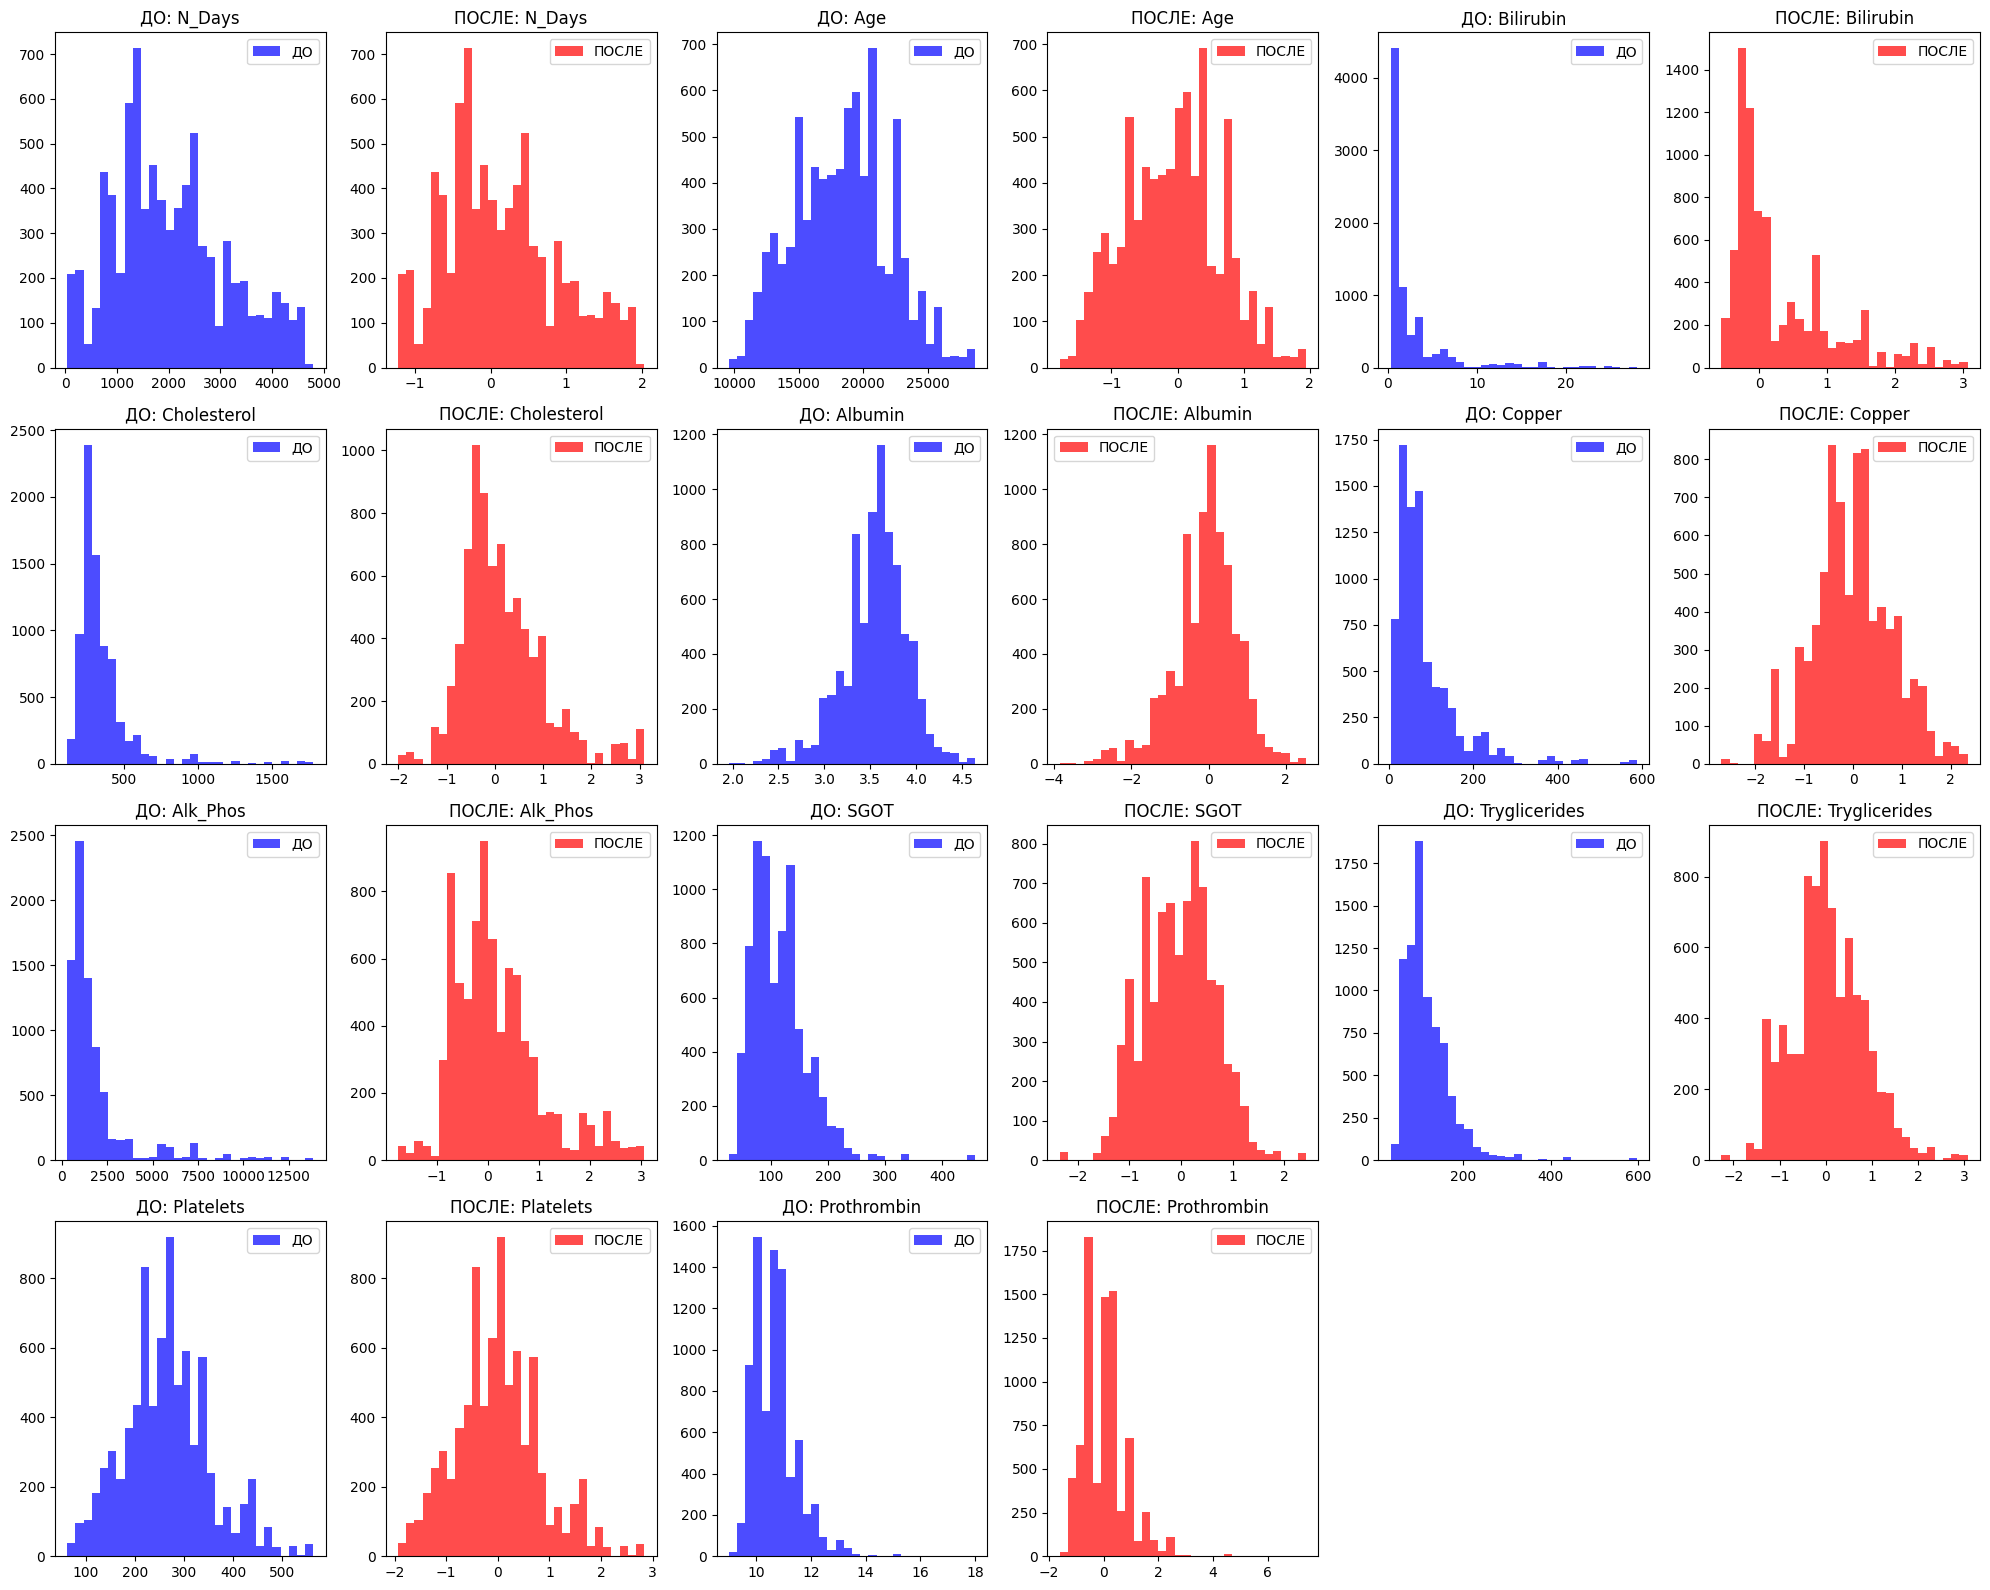

In [45]:
# Визуализация числовых признаков
def compare_numeric_distributions(original_df, processed_df, numeric_features, n_cols=3):
    n_features = len(numeric_features)
    n_rows = (n_features + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols*2, figsize=(20, 4*n_rows))
    axes = axes.ravel()

    for i, col in enumerate(numeric_features):
        # ДО преобразования
        axes[i*2].hist(original_df[col], bins=30, alpha=0.7, color='blue', label='ДО')
        axes[i*2].set_title(f'ДО: {col}')
        axes[i*2].legend()

        # ПОСЛЕ преобразования
        axes[i*2+1].hist(processed_df[col], bins=30, alpha=0.7, color='red', label='ПОСЛЕ')
        axes[i*2+1].set_title(f'ПОСЛЕ: {col}')
        axes[i*2+1].legend()

    # Скрываем лишние subplots
    for j in range(n_features*2, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

print("=== СРАВНЕНИЕ ЧИСЛОВЫХ ПРИЗНАКОВ ===")
compare_numeric_distributions(df, processed_df, numeric_features)

2. Сравнение выбросов ДО/ПОСЛЕ


=== СРАВНЕНИЕ ВЫБРОСОВ ===


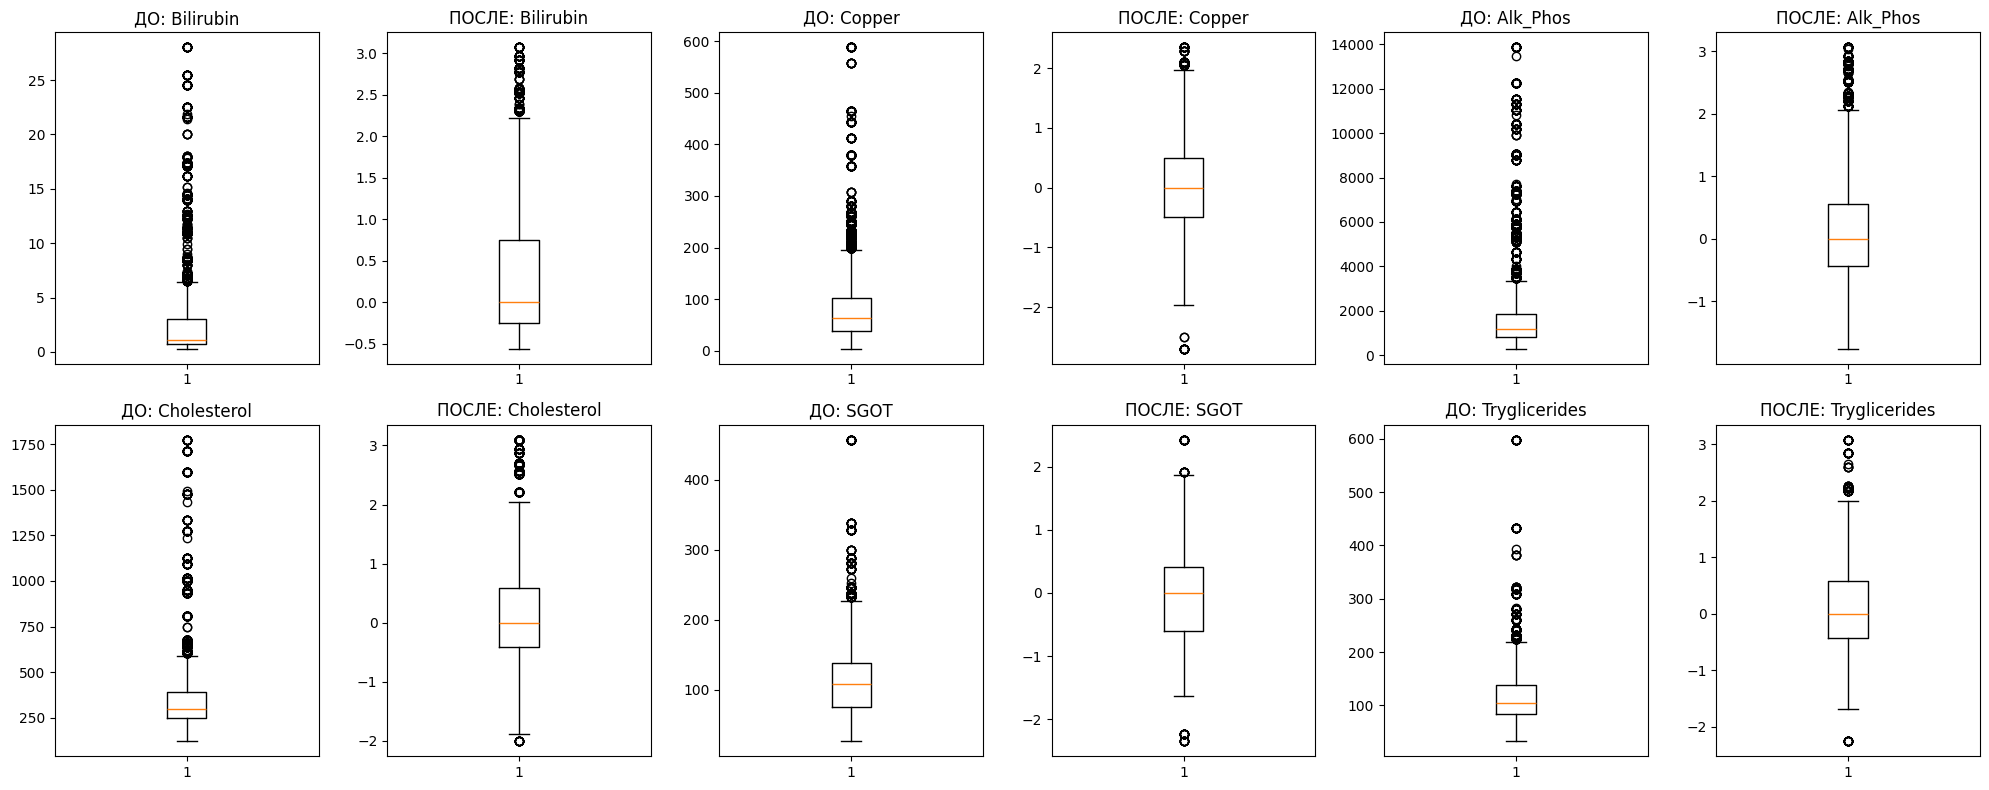

In [46]:
def compare_outliers(original_df, processed_df, numeric_features, n_cols=3):
    n_features = len(numeric_features)
    n_rows = (n_features + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols*2, figsize=(20, 4*n_rows))
    axes = axes.ravel()

    for i, col in enumerate(numeric_features):
        # ДО обработки выбросов
        axes[i*2].boxplot(original_df[col])
        axes[i*2].set_title(f'ДО: {col}')

        # ПОСЛЕ обработки выбросов
        axes[i*2+1].boxplot(processed_df[col])
        axes[i*2+1].set_title(f'ПОСЛЕ: {col}')

    for j in range(n_features*2, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

print("=== СРАВНЕНИЕ ВЫБРОСОВ ===")
compare_outliers(df, processed_df, ['Bilirubin', 'Copper', 'Alk_Phos', 'Cholesterol', 'SGOT', 'Tryglicerides'])

3. Статистика по выбросам


In [47]:
def correct_outlier_statistics(original_df, processed_df, numeric_features, preprocessor):
    stats = []

    # Получаем трансформер выбросов
    clip_transformer = preprocessor.named_transformers_['numeric'].named_steps['outlier_clip']

    for col in numeric_features:
        if col in clip_transformer.clipping_bounds_:
            lower_bound, upper_bound = clip_transformer.clipping_bounds_[col]

            # ПРАВИЛЬНО: считаем проценты на логарифмированных данных
            X_logged = np.log1p(original_df[col])  # Сначала логарифмируем
            pct_lower = (X_logged < lower_bound).mean() * 100
            pct_upper = (X_logged > upper_bound).mean() * 100
            total_clipped = pct_lower + pct_upper

            # Для диапазона - переводим обратно в исходную шкалу
            orig_range = original_df[col].max() - original_df[col].min()
            proc_max_orig = np.expm1(processed_df[col].max())
            proc_min_orig = np.expm1(processed_df[col].min())
            proc_range = proc_max_orig - proc_min_orig
            range_reduction = ((orig_range - proc_range) / orig_range) * 100

            stats.append({
                'Признак': col,
                'Нижняя граница': f'{lower_bound:.2f}',
                'Верхняя граница': f'{upper_bound:.2f}',
                '% обрезано снизу': f'{pct_lower:.1f}%',
                '% обрезано сверху': f'{pct_upper:.1f}%',
                '% всего обрезано': f'{total_clipped:.1f}%',
                'Сжатие диапазона': f'{range_reduction:.1f}%'
            })

    return pd.DataFrame(stats)

print("=== СТАТИСТИКА ВЫБРОСОВ ===")
correct_stats = correct_outlier_statistics(df, processed_df, numeric_features, preprocessor)
print(correct_stats)

=== СТАТИСТИКА ВЫБРОСОВ ===
         Признак Нижняя граница Верхняя граница % обрезано снизу  \
0         N_Days       -2417.50         6336.50             0.0%   
1      Bilirubin          -1.61            3.53             0.0%   
2    Cholesterol           4.39            7.10             0.0%   
3         Copper           1.32            7.00             0.0%   
4       Alk_Phos           4.73            9.53             0.0%   
5           SGOT           2.87            6.41             0.0%   
6  Tryglicerides           3.20            6.19             0.0%   
7      Platelets         -51.50          578.50             0.0%   

  % обрезано сверху % всего обрезано Сжатие диапазона  
0              0.0%             0.0%            99.8%  
1              0.0%             0.0%            24.4%  
2              1.2%             1.2%            98.7%  
3              0.0%             0.0%            98.2%  
4              0.2%             0.2%            99.8%  
5              0.0%    

4. Проверка кодирования категориальных признаков


In [30]:
def check_encoding(original_df, processed_df, binary_features, multi_category_features):
    print("=== ПРОВЕРКА КОДИРОВАНИЯ ===")

    # Бинарные признаки
    print("\n--- БИНАРНЫЕ ПРИЗНАКИ ---")
    for feature in binary_features:
        print(f"\n{feature}:")
        print(f"  ДО: {original_df[feature].unique()} -> {dict(original_df[feature].value_counts())}")
        print(f"  ПОСЛЕ: {processed_df[feature].unique()} -> {dict(processed_df[feature].value_counts())}")

    # Многоклассовые признаки
    print("\n--- МНОГОКЛАССОВЫЕ ПРИЗНАКИ ---")
    categorical_cols = [col for col in processed_df.columns if any(x in col for x in multi_category_features)]
    for col in categorical_cols:
        print(f"{col}: {processed_df[col].unique()}")

check_encoding(df, processed_df, binary_features, multi_category_features)

=== ПРОВЕРКА КОДИРОВАНИЯ ===

--- БИНАРНЫЕ ПРИЗНАКИ ---

Sex:
  ДО: ['M' 'F'] -> {'F': np.int64(7336), 'M': np.int64(569)}
  ПОСЛЕ: [1. 0.] -> {0.0: np.int64(7336), 1.0: np.int64(569)}

Ascites:
  ДО: ['N' 'Y'] -> {'N': np.int64(7525), 'Y': np.int64(380)}
  ПОСЛЕ: [0. 1.] -> {0.0: np.int64(7525), 1.0: np.int64(380)}

Hepatomegaly:
  ДО: ['N' 'Y'] -> {'Y': np.int64(4042), 'N': np.int64(3863)}
  ПОСЛЕ: [0. 1.] -> {1.0: np.int64(4042), 0.0: np.int64(3863)}

Spiders:
  ДО: ['N' 'Y'] -> {'N': np.int64(5966), 'Y': np.int64(1939)}
  ПОСЛЕ: [0. 1.] -> {0.0: np.int64(5966), 1.0: np.int64(1939)}

--- МНОГОКЛАССОВЫЕ ПРИЗНАКИ ---
Drug_Placebo: [0. 1.]
Edema_S: [0. 1.]
Edema_Y: [0. 1.]
Stage_2.0: [0. 1.]
Stage_3.0: [1. 0.]
Stage_4.0: [0. 1.]


5. Общая информация о преобразованиях


In [31]:
def transformation_summary(original_df, processed_df):
    print("=== ОБЩАЯ СВОДКА ===")
    print(f"Размер ДО: {original_df.shape}")
    print(f"Размер ПОСЛЕ: {processed_df.shape}")

    print(f"\nТипы данных ДО:")
    print(original_df.dtypes.value_counts())

    print(f"\nТипы данных ПОСЛЕ:")
    print(processed_df.dtypes.value_counts())

    print(f"\nДиапазоны ключевых признаков:")
    key_features = ['Bilirubin', 'Copper', 'Alk_Phos', 'Cholesterol']
    for col in key_features:
        if col in original_df.columns and col in processed_df.columns:
            print(f"{col}: {original_df[col].min():.2f}-{original_df[col].max():.2f} -> {processed_df[col].min():.2f}-{processed_df[col].max():.2f}")

transformation_summary(df, processed_df)

=== ОБЩАЯ СВОДКА ===
Размер ДО: (7905, 19)
Размер ПОСЛЕ: (7905, 21)

Типы данных ДО:
float64    10
object      7
int64       2
Name: count, dtype: int64

Типы данных ПОСЛЕ:
float64    21
Name: count, dtype: int64

Диапазоны ключевых признаков:
Bilirubin: 0.30-28.00 -> -0.56-3.07
Copper: 4.00-588.00 -> -2.70-2.35
Alk_Phos: 289.00-13862.40 -> -1.76-3.07
Cholesterol: 120.00-1775.00 -> -2.00-3.09
